In [1]:
import re
from pathlib import Path
from typing import Dict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def parse_and_plot_matrices(
    *,
    n_features: int,                 # <-- new REQUIRED argument
    file_path: str = "",
    raw_text: str = "",
) -> Dict[int, np.ndarray]:
    """
    Parse projection matrices from the new edge-list log format (and the old
    dense format for backward compatibility) and plot them.

    Parameters
    ----------
    n_features : int   (required)
        Total number of numerical features in the data set.  Every matrix will
        have exactly this number of columns.
    file_path : str
        Path to the log file.  Ignored if `raw_text` is provided.
    raw_text : str
        The log content as a string.

    Returns
    -------
    dict[int, np.ndarray]
        Mapping  node_id -> (n_projections × n_features) numpy matrix.
    """
    if n_features <= 0:
        raise ValueError("n_features must be a positive integer")

    # ------------------------------------------------------------------ #
    # 1.  Load text                                                      #
    # ------------------------------------------------------------------ #
    text = raw_text if raw_text else Path(file_path).read_text()

    # ------------------------------------------------------------------ #
    # 2.  Parse                                                          #
    # ------------------------------------------------------------------ #
    def parse_matrices(text_: str) -> Dict[int, np.ndarray]:
        matrices: Dict[int, np.ndarray] = {}

        # --- new edge-list blocks --------------------------------------
        node_re = re.compile(
            r"Node\s+(\d+)\s*\|\s*(\d+)\s+projections(.*?)(?=Node\s+\d+\s*\||\Z)",
            re.S,
        )

        for node_id_str, n_proj_str, block in node_re.findall(text_):
            node_id = int(node_id_str)
            n_proj = int(n_proj_str)

            mat = np.zeros((n_proj, n_features), dtype=int)

            for line in block.strip().splitlines():
                tokens = line.strip().split()
                if len(tokens) == 3 and tokens[0].isdigit():
                    p, f, w = map(int, tokens)
                    if not (0 <= f < n_features):
                        raise ValueError(
                            f"Feature index {f} in node {node_id} "
                            f"exceeds n_features-1 = {n_features-1}"
                        )
                    if not (0 <= p < n_proj):
                        raise ValueError(
                            f"Projection index {p} in node {node_id} "
                            f"exceeds n_proj-1 = {n_proj-1}"
                        )
                    mat[p, f] = w

            matrices[node_id] = mat

        # --- old dense "proj…" blocks (optional) -----------------------
        old_re = re.compile(r"Node\s+(\d+)(.*?proj.*?)(?=Node\s+\d+|$)", re.S)
        for node_id_str, block in old_re.findall(text_):
            node_id = int(node_id_str)
            rows = []
            for line in block.splitlines():
                line = line.strip()
                if line.startswith("proj"):
                    values = list(map(int, line.split()[2:]))
                    rows.append(values)

            if rows:
                dense = np.asarray(rows, dtype=int)
                if dense.shape[1] > n_features:
                    raise ValueError(
                        f"Old-format matrix for node {node_id} has "
                        f"{dense.shape[1]} columns, exceeds n_features={n_features}"
                    )
                # pad to n_features on the right
                pad_width = n_features - dense.shape[1]
                if pad_width:
                    dense = np.pad(dense, ((0, 0), (0, pad_width)))
                matrices[node_id] = dense

        return matrices

    matrices = parse_matrices(text)

    # ------------------------------------------------------------------ #
    # 3.  Diagnostics                                                    #
    # ------------------------------------------------------------------ #
    if matrices:
        print(f"Using n_features = {n_features}")
        first_shape = next(iter(matrices.values())).shape
        print(f"Example matrix dimensions: {first_shape}")
        print(f"Parsed {len(matrices)} nodes:", list(matrices.keys()))

        for node_id, matrix in matrices.items():
            avg_nonzeros = np.count_nonzero(matrix, axis=1).mean()
            print(f"Node {node_id}: average non-zeros / row = {avg_nonzeros:.2f}")

    # ------------------------------------------------------------------ #
    # 4.  Plotting                                                       #
    # ------------------------------------------------------------------ #
    cmap = ListedColormap(["orange", "white", "green"])

    for node, mat in matrices.items():
        fig, ax = plt.subplots()
        im = ax.imshow(
            mat, aspect="auto", cmap=cmap, interpolation="none", vmin=-1, vmax=1
        )
        ax.set_title(f"Node {node}")
        ax.set_xlabel("feature")
        ax.set_ylabel("projection")
        ax.set_xticks(range(n_features))
        ax.set_yticks(range(mat.shape[0]))
        cbar = fig.colorbar(im, ax=ax, ticks=[-1, 0, 1])
        cbar.set_label("Projection Weight")
        cbar.ax.set_yticklabels(["-1", "0", "1"])
        plt.show()
        plt.close(fig)

    return matrices

Using n_features = 2523
Example matrix dimensions: (51, 2523)
Parsed 13 nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Node 0: average non-zeros / row = 1.51
Node 1: average non-zeros / row = 1.63
Node 2: average non-zeros / row = 1.75
Node 3: average non-zeros / row = 1.78
Node 4: average non-zeros / row = 1.92
Node 5: average non-zeros / row = 1.53
Node 6: average non-zeros / row = 1.80
Node 7: average non-zeros / row = 1.67
Node 8: average non-zeros / row = 1.63
Node 9: average non-zeros / row = 1.82
Node 10: average non-zeros / row = 1.69
Node 11: average non-zeros / row = 1.73
Node 12: average non-zeros / row = 1.63


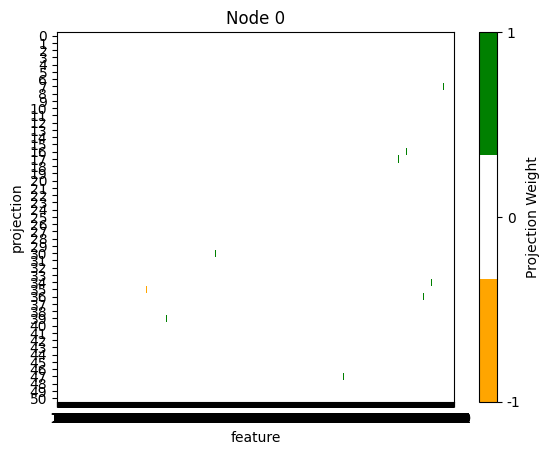

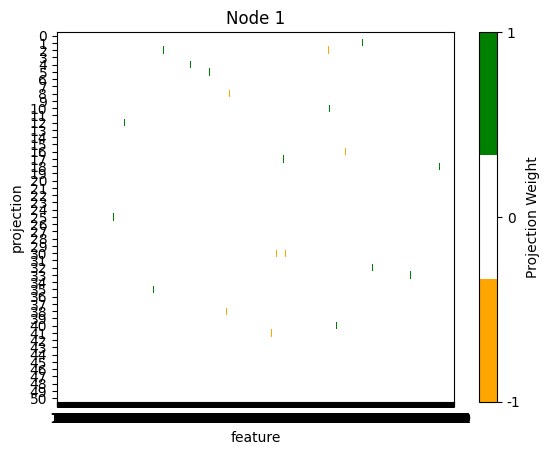

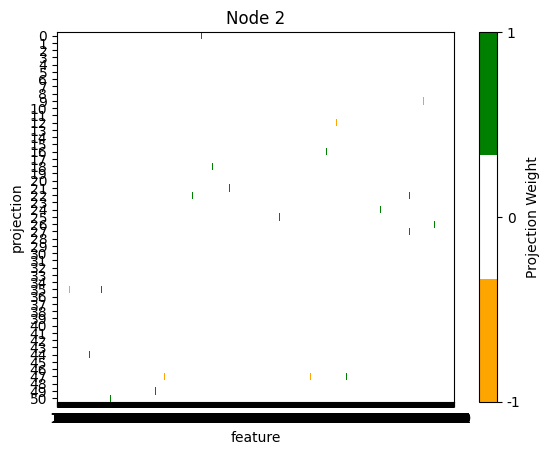

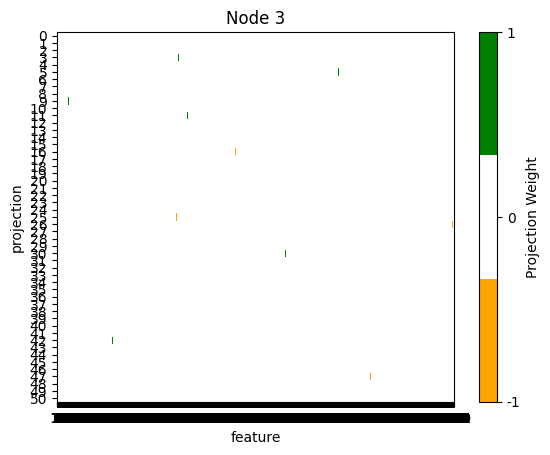

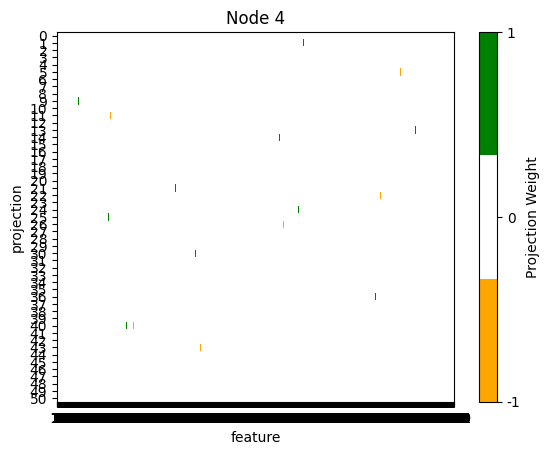

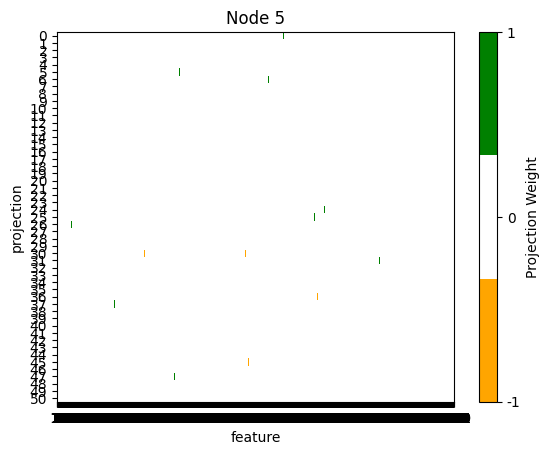

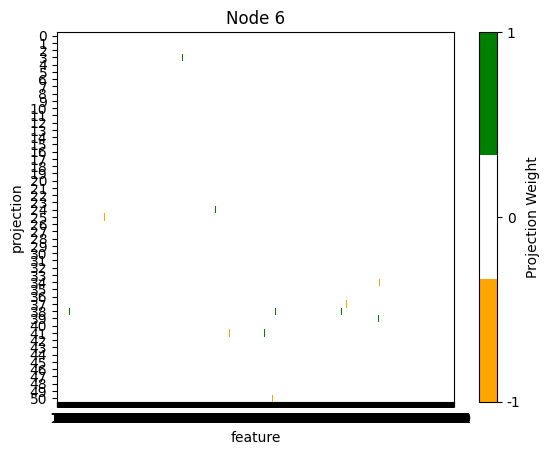

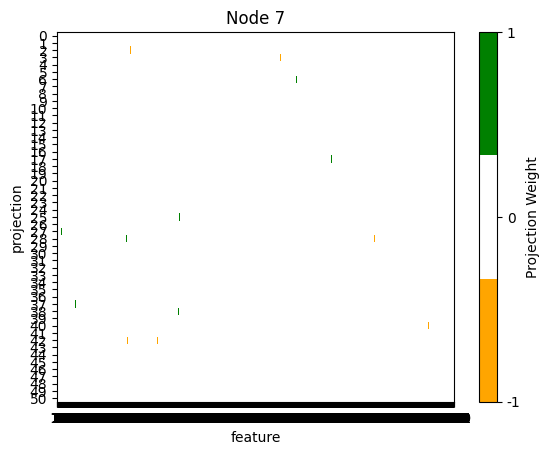

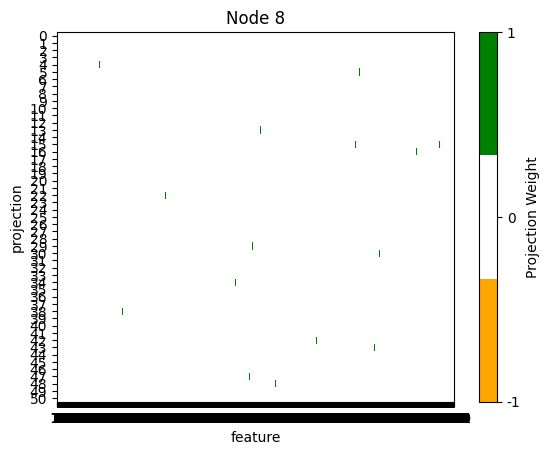

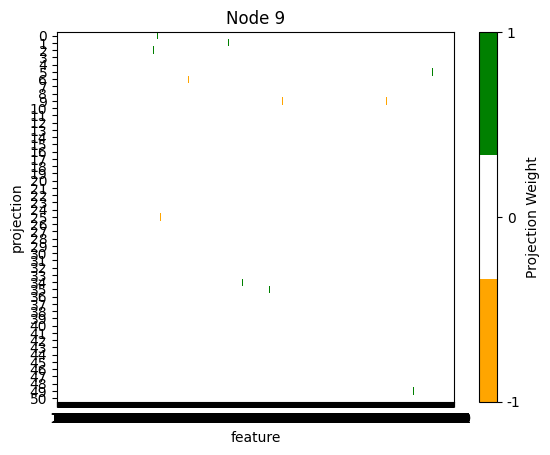

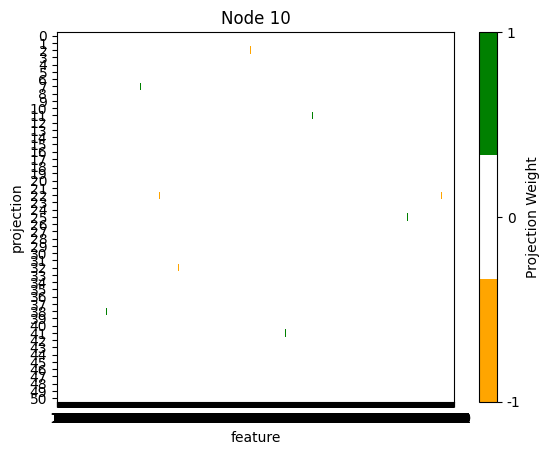

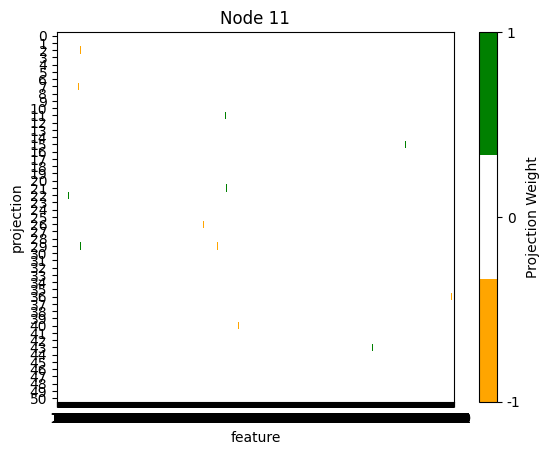

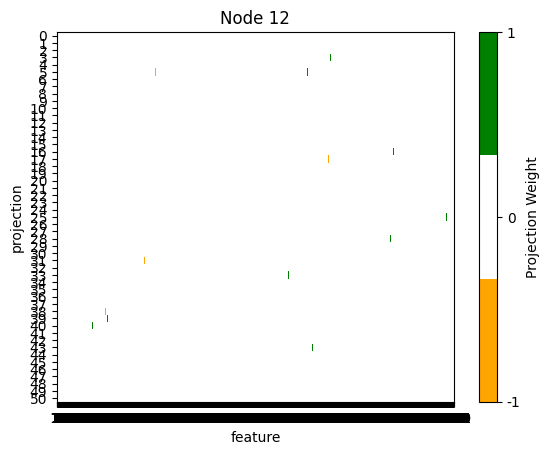

In [3]:
_ = parse_and_plot_matrices(file_path="../results/ydf_projection_matrices/projection_matrices.txt", n_features=2523)